In [62]:
from utils7 import *
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve, accuracy_score, precision_recall_curve, average_precision_score
from itertools import compress
import seaborn as sns

%matplotlib inline

**FairFace dataframe is created by consolidating Rekognition results and labels:**

In [2]:
finished_product = sample_and_combine_labels_and_results()
finished_product

,filename,Race,Label,Prediction,Confidence,Faces,Boundingbox
0,train/10.jpg,Middle Eastern,Male,Male,98.520317,1,"{'Width': 0.7955519556999207, 'Height': 1.0746..."
1,train/100.jpg,East Asian,Female,Female,99.193069,1,"{'Width': 0.6965078711509705, 'Height': 0.9889..."
2,train/1000.jpg,White,Male,Male,90.857079,1,"{'Width': 0.6960622668266296, 'Height': 1.0068..."
3,train/10001.jpg,Latino_Hispanic,Female,Female,97.441849,1,"{'Width': 0.8161835074424744, 'Height': 1.0971..."
4,train/10003.jpg,East Asian,Male,Female,51.301563,1,"{'Width': 0.7959486246109009, 'Height': 0.9763..."
...,...,...,...,...,...,...,...
2795,train/15699.jpg,Middle Eastern,Female,Female,97.950241,1,"{'Width': 0.7606130838394165, 'Height': 0.9907..."
2796,train/15730.jpg,Middle Eastern,Female,Female,98.159409,1,"{'Width': 0.7935853600502014, 'Height': 1.1358..."
2797,train/15769.jpg,Middle Eastern,Female,Female,95.164230,1,"{'Width': 0.8295945525169373, 'Height': 1.0948..."
2798,train/15774.jpg,Middle Eastern,Female,Female,58.024311,1,"{'Width': 0.6956198811531067, 'Height': 0.9878..."


In [75]:
label_list = list(finished_product['Label'])
pred_list = list(finished_product['Prediction'])
conf_list = list(finished_product['Confidence'])
race_list = list(finished_product['Race'])

unique_race_list = ["East Asian", "Middle Eastern", "White", "Latino_Hispanic", "Indian", "Southeast Asian", "Black"]
races_with_all = ["All"] + unique_race_list

**We stablish confidence threshold and compute metrics:**

In [76]:
confidence_threshold = 99.0

In [77]:
metrics_df, metrics_dict = metrics_dataframe(finished_product, confidence_threshold)
display(HTML(metrics_df.to_html()))
metrics_df.to_csv("figures200/FairFace_Metrics_DataFrame.csv")

,Female,Male
All,"{'Precision': 0.9809322033898306, 'Prec_ci_lower': 0.9627995066914204, 'Prec_ci_upper': 0.9912997874835237, 'FDR': 0.01906779661016944, 'FDR_ci_lower': 0.00933356995587511, 'FDR_ci_upper': 0.03656713586918078, 'Recall': 0.33071428571428574, 'Reca_ci_lower': 0.30621315382034275, 'Reca_ci_upper': 0.35614188134282554, 'FPR': 0.0064285714285714285, 'FPR_ci_lower': 0.0031405220470304873, 'FPR_ci_upper': 0.012417829420265671, 'FNR': 0.6692857142857143, 'FNR_ci_lower': 0.643844713180163, 'FNR_ci_upper': 0.6938002516566689, 'TP': 463, 'FP': 9, 'TP+FP': 472, 'num_pos': 1400, 'num_neg': 1400}","{'Precision': 0.9868421052631579, 'Prec_ci_lower': 0.9483774159044169, 'Prec_ci_upper': 1, 'FDR': 0.013157894736842146, 'FDR_ci_lower': 0.0022823214746250093, 'FDR_ci_upper': 0.048034576737398534, 'Recall': 0.10714285714285714, 'Reca_ci_lower': 0.09167029669627333, 'Reca_ci_upper': 0.12476543891445446, 'FPR': 0.0014285714285714286, 'FPR_ci_lower': 0.00024747980380912174, 'FPR_ci_upper': 0.005338235571259935, 'FNR': 0.8928571428571429, 'FNR_ci_lower': 0.8751873355094985, 'FNR_ci_upper': 0.908376928879774, 'TP': 150, 'FP': 2, 'TP+FP': 152, 'num_pos': 1400, 'num_neg': 1400}"
Middle Eastern,"{'Precision': 1.0, 'Prec_ci_lower': 0.9429074445348157, 'Prec_ci_upper': 1, 'FDR': 0.0, 'FDR_ci_lower': 0, 'FDR_ci_upper': 0.04468013019942555, 'Recall': 0.4, 'Reca_ci_lower': 0.33222250118782853, 'Reca_ci_upper': 0.4715465640876248, 'FPR': 0.0, 'FPR_ci_lower': 0, 'FPR_ci_upper': 0.018390576182199844, 'FNR': 0.6, 'FNR_ci_lower': 0.5283160193687717, 'FNR_ci_upper': 0.6679149153557751, 'TP': 80, 'FP': 0, 'TP+FP': 80, 'num_pos': 200, 'num_neg': 200}","{'Precision': 1.0, 'Prec_ci_lower': 0.834226992511688, 'Prec_ci_upper': 1, 'FDR': 0.0, 'FDR_ci_lower': 0, 'FDR_ci_upper': 0.12953734149537208, 'Recall': 0.125, 'Reca_ci_lower': 0.08404695835593035, 'Reca_ci_upper': 0.1800870364270196, 'FPR': 0.0, 'FPR_ci_lower': 0, 'FPR_ci_upper': 0.018390576182199844, 'FNR': 0.875, 'FNR_ci_lower': 0.8191583764427199, 'FNR_ci_upper': 0.9167076287743301, 'TP': 25, 'FP': 0, 'TP+FP': 25, 'num_pos': 200, 'num_neg': 200}"
East Asian,"{'Precision': 1.0, 'Prec_ci_lower': 0.9314707191371822, 'Prec_ci_upper': 1, 'FDR': 0.0, 'FDR_ci_lower': 0, 'FDR_ci_upper': 0.05362268096486642, 'Recall': 0.33, 'Reca_ci_lower': 0.2662439728519619, 'Reca_ci_upper': 0.4001634381163088, 'FPR': 0.0, 'FPR_ci_lower': 0, 'FPR_ci_upper': 0.018390576182199844, 'FNR': 0.6699999999999999, 'FNR_ci_lower': 0.5995933770962109, 'FNR_ci_upper': 0.7339992119355185, 'TP': 66, 'FP': 0, 'TP+FP': 66, 'num_pos': 200, 'num_neg': 200}","{'Precision': 1.0, 'Prec_ci_lower': 0.8150249368033352, 'Prec_ci_upper': 1, 'FDR': 0.0, 'FDR_ci_lower': 0, 'FDR_ci_upper': 0.14449854115638602, 'Recall': 0.11, 'Reca_ci_lower': 0.07173657983164276, 'Reca_ci_upper': 0.1629627747426252, 'FPR': 0.0, 'FPR_ci_lower': 0, 'FPR_ci_upper': 0.018390576182199844, 'FNR': 0.89, 'FNR_ci_lower': 0.836209761663897, 'FNR_ci_upper': 0.929090883761835, 'TP': 22, 'FP': 0, 'TP+FP': 22, 'num_pos': 200, 'num_neg': 200}"
White,"{'Precision': 1.0, 'Prec_ci_lower': 0.9407899812092608, 'Prec_ci_upper': 1, 'FDR': 0.0, 'FDR_ci_lower': 0, 'FDR_ci_upper': 0.046336012326804635, 'Recall': 0.385, 'Reca_ci_lower': 0.31796066268401996, 'Reca_ci_upper': 0.45637376238275135, 'FPR': 0.0, 'FPR_ci_lower': 0, 'FPR_ci_upper': 0.018390576182199844, 'FNR': 0.615, 'FNR_ci_lower': 0.5434671572052227, 'FNR_ci_upper': 0.682198417728006, 'TP': 77, 'FP': 0, 'TP+FP': 77, 'num_pos': 200, 'num_neg': 200}","{'Precision': 1.0, 'Prec_ci_lower': 0.8543835244204265, 'Prec_ci_upper': 1, 'FDR': 0.0, 'FDR_ci_lower': 0, 'FDR_ci_upper': 0.11382133051321372, 'Recall': 0.145, 'Reca_ci_lower': 0.10077927376416668, 'Reca_ci_upper': 0.20260090796369254, 'FPR': 0.0, 'FPR_ci_lower': 0, 'FPR_ci_upper': 0.018390576182199844, 'FNR': 0.855, 'FNR_ci_lower': 0.7967264702532597, 'FNR_ci_upper': 0.899893348018881, 'TP': 29, 'FP': 0, 'TP+FP': 29, 'num_pos': 200, 'num_neg': 200}"
Latino_Hispanic,"{'Precision': 0.9

In [18]:
def plot_metric_with_ci(metric, mdf, race_list, yaxis_label):
    female_metric = [mdf["Female"][race][metric]*100 for race in race_list]
    male_metric = [mdf["Male"][race][metric]*100 for race in race_list]
    
    female_metric_lower = [mdf["Female"][race][metric]*100 - mdf["Female"][race][metric+"_ci_lower"]*100 for race in race_list]
    female_metric_upper = [mdf["Female"][race][metric+"_ci_upper"]*100 - mdf["Female"][race][metric]*100 for race in race_list]
    female_metric_ci = np.row_stack((female_metric_lower, female_metric_upper))

    male_metric_lower = [mdf["Male"][race][metric]*100 - mdf["Male"][race][metric+"_ci_lower"]*100 for race in race_list]
    male_metric_upper = [mdf["Male"][race][metric+"_ci_upper"]*100 - mdf["Male"][race][metric]*100 for race in race_list]
    male_metric_ci = np.row_stack((male_metric_lower, male_metric_upper))
    
    barWidth = 0.35
    r1 = np.arange(len(female_metric))
    r2 = [x + barWidth for x in r1]
    
    plt.bar(r1, female_metric, width=barWidth, color="sandybrown", edgecolor="black", yerr=female_metric_ci, capsize=7, label="Female")
    plt.bar(r2, male_metric, width=barWidth, color="lightskyblue", edgecolor="black", yerr=male_metric_ci, capsize=7, label="Male")
    
    plt.xticks([r + barWidth/2 for r in range(len(female_metric))], race_list, FontSize=22)
    plt.ylabel(yaxis_label+" (%)")
    plt.grid(True)
    plt.legend()

**Plots the error rate (FDR) per gender and ethnicity:**

<ipython-input-18-84202c7bcf0b>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks([r + barWidth/2 for r in range(len(female_metric))], race_list, FontSize=22)


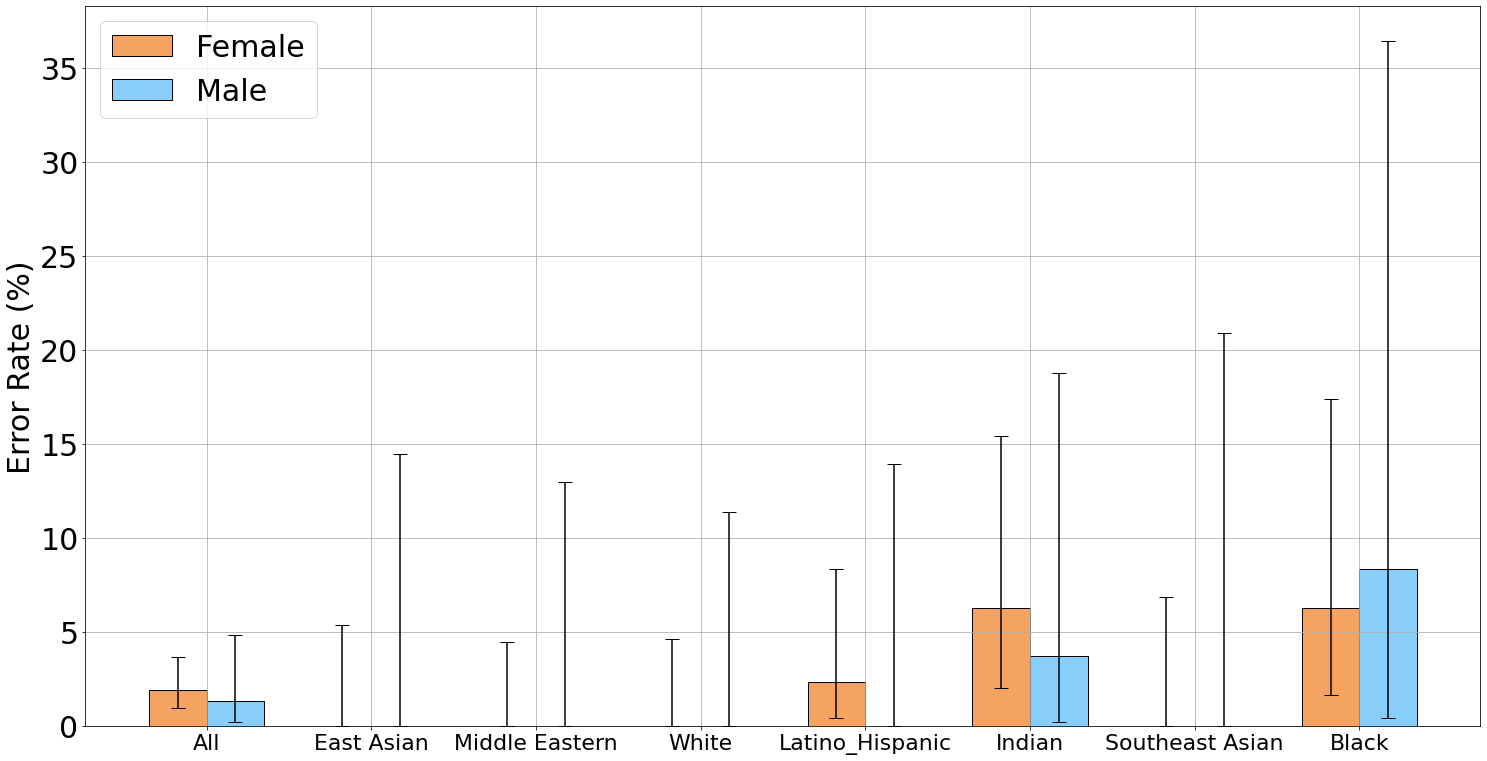

In [22]:
plt.figure(figsize=(25,45))
plt.rcParams.update({"font.size": 30})

metric = "FDR"
yaxis_label = "Error Rate"
plt.subplot(3, 1, 1)
plot_metric_with_ci(metric, metrics_df, races_with_all, yaxis_label)

filename = "figures200/FairFace_FDR_CI.png"
plt.savefig(filename)

In [23]:
def plot_pr_curve(label_list, pred_list, conf_list, thresholds_to_plot=[99,90,80,70,60,50], beta=1, title=''):
    for gender in sorted(set(label_list)):    
      confidence_list = [conf if pred==gender else 100.0 - conf for pred,conf in zip(pred_list, conf_list)]

      prec, reca, thresholds = precision_recall_curve(label_list, confidence_list, pos_label=gender)
      ap = average_precision_score(label_list, confidence_list, pos_label=gender)
      plt.plot(reca, prec, label=gender+' (AP = %0.2f)' % ap, linewidth=2)
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title(title)
      plt.legend(loc="lower left")
      plt.grid(True)

      for th in thresholds_to_plot:
        closest_to_th = min(thresholds, key=lambda x:abs(x-th))
        idx = np.where(thresholds==closest_to_th)
        plt.text(reca[idx], prec[idx], '{:d} - {:s}'.format(round(float(thresholds[idx])),gender), fontdict={'size': 12}, rotation=-90, va='top')

**Plots the Precision-Recall curves per gender and ethnicity:**

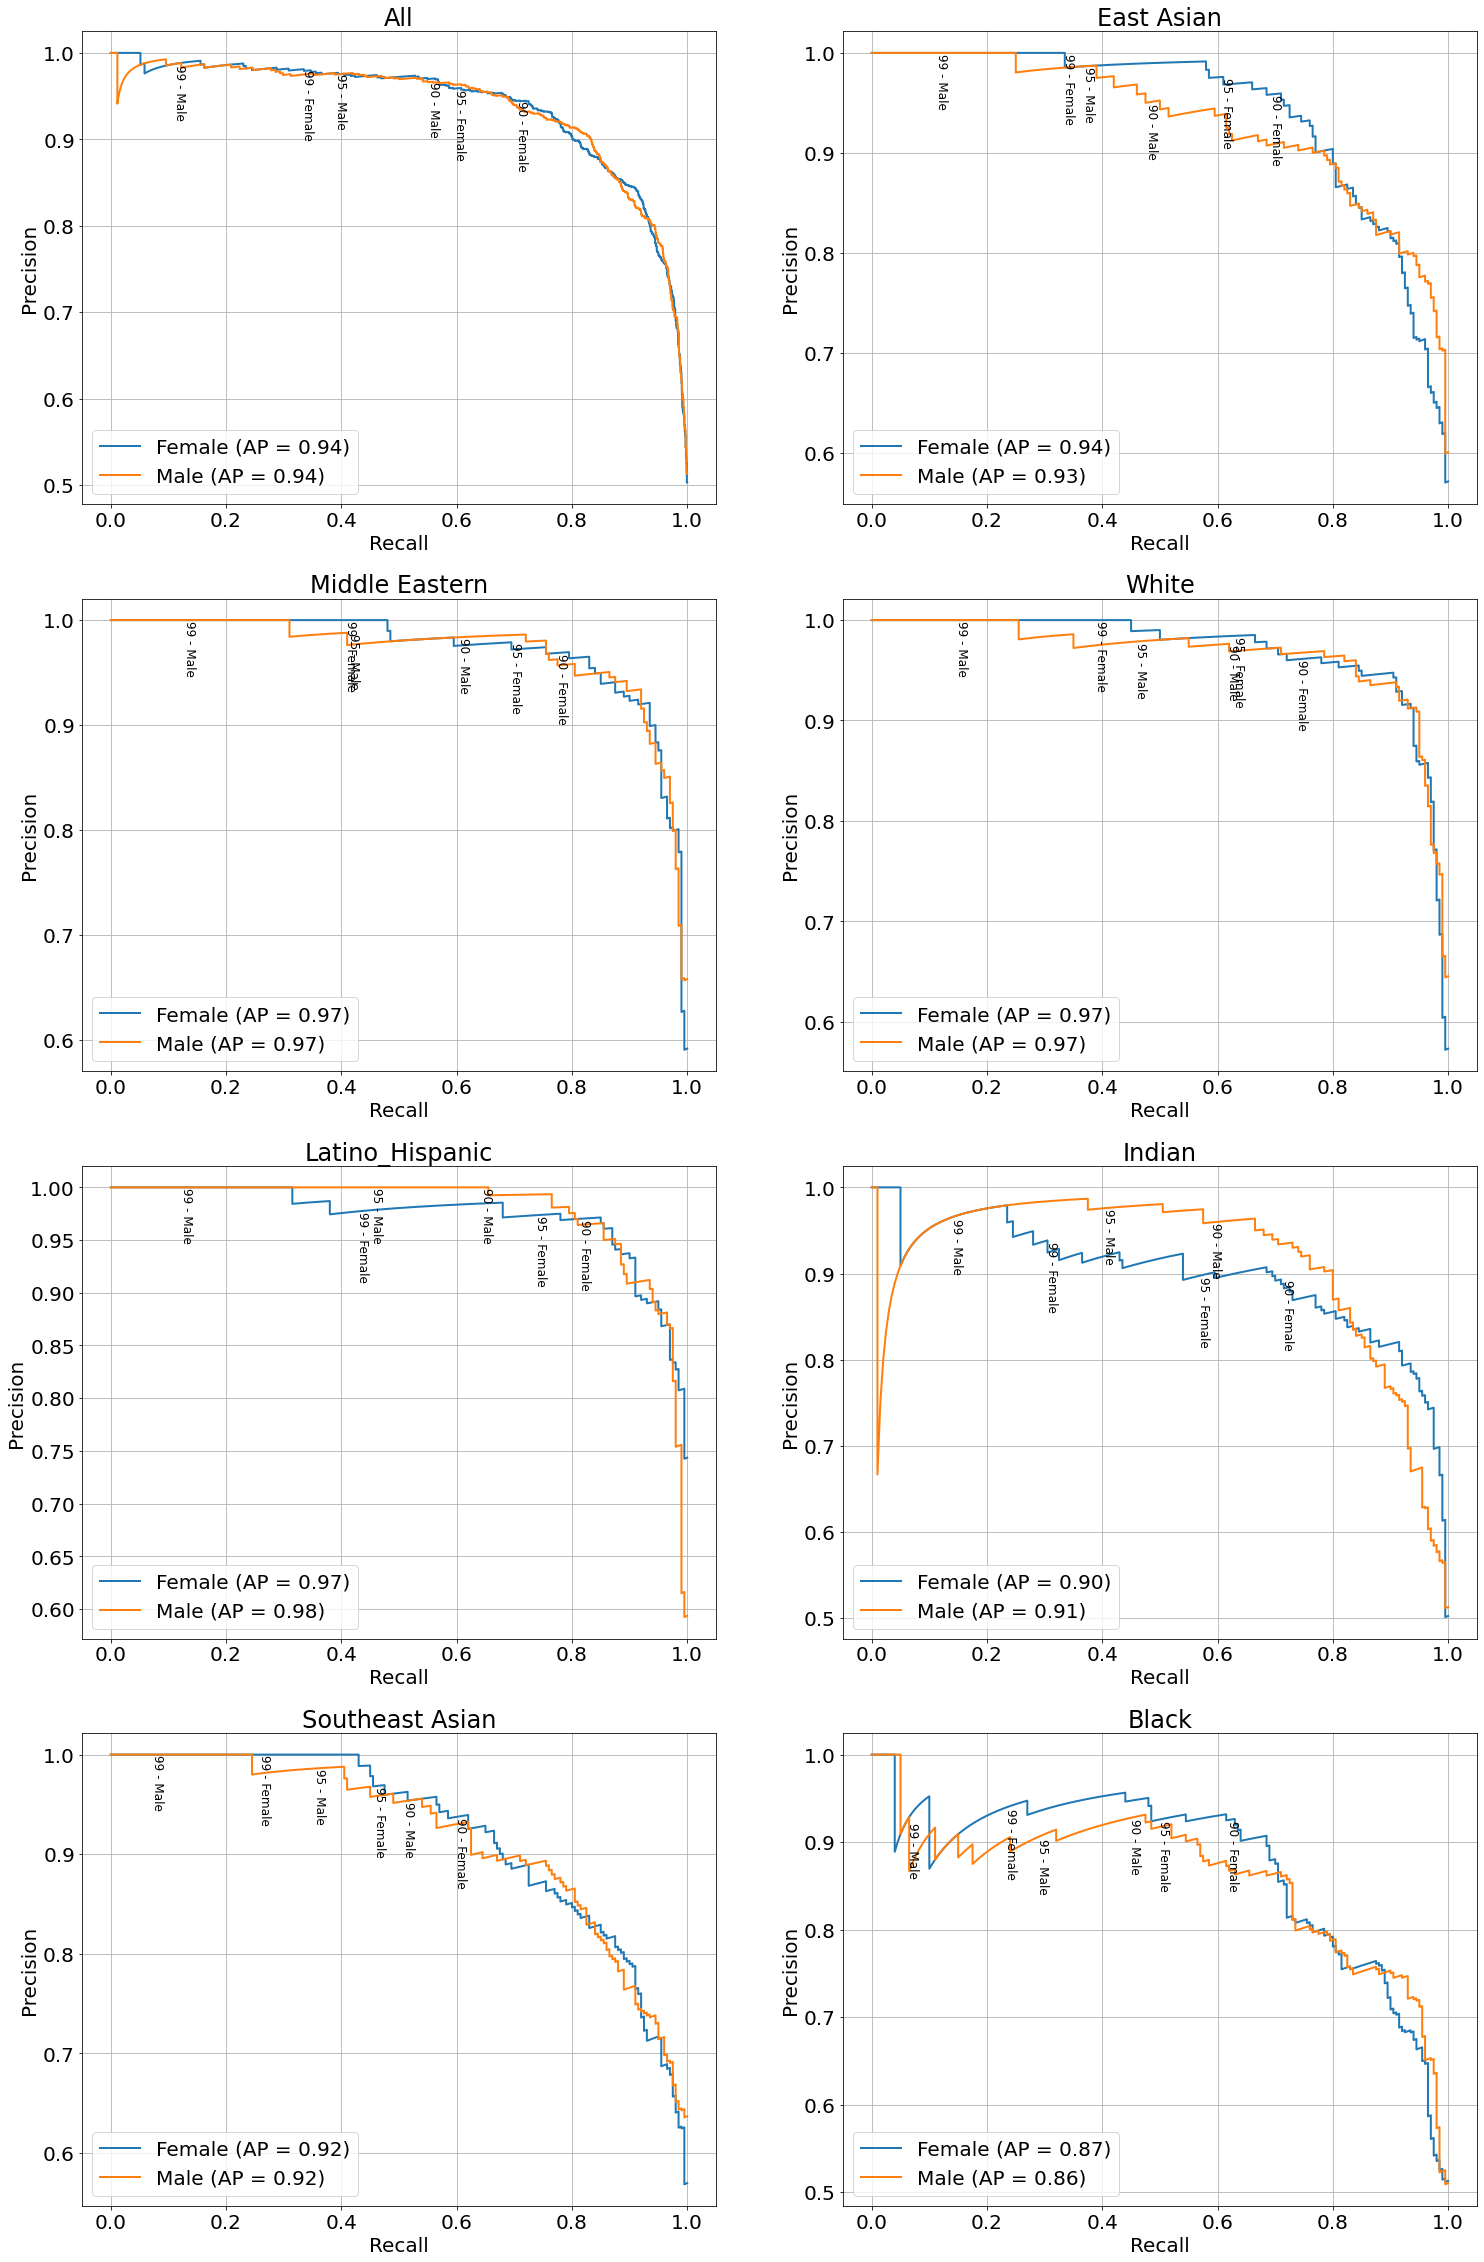

In [31]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(25,40))
thresholds = [99,95,90]
plt.subplot(4,2,1)
plot_pr_curve(label_list,pred_list,conf_list,title='All',thresholds_to_plot=thresholds)
for i,race in enumerate(unique_race_list):
    race_bool = [value==race for value in race_list]
    race_labels = list(compress(label_list, race_bool))
    race_pred = list(compress(pred_list, race_bool))
    race_conf = list(compress(conf_list, race_bool))

    plt.subplot(4,2,i+2)
    plot_pr_curve(race_labels,race_pred,race_conf,title=race,thresholds_to_plot=thresholds)

filename = "figures200/FairFace_PRC.png"
plt.savefig(filename)

In [63]:
def plot_hists(labels_list, pred_list, conf_list, title=''):
  pos_class = "Female"
  confidence_list = [conf if pred==pos_class else 100.0 - conf for pred,conf in zip(pred_list, conf_list)]
  hist_dict = dict()
  for gender in set(labels_list):
      gender_conf = [conf for label, conf in zip(labels_list,confidence_list) if label==gender]
      ax = sns.distplot(gender_conf, kde=False,label=gender, bins=range(0,101))
      ax.set_yscale("log")
  plt.legend(loc="upper center")
  if title=="Southeast Asian" or title=="Black":
      plt.xlabel("Threshold (Confidence)")
  if title=="All" or title=="Latino_Hispanic" or title=="Southeast Asian" or title=="Middle Eastern": 
      plt.ylabel("Number")
  _,top = plt.ylim()
  
  plt.plot([50, 50], [0, top], color="black", linewidth=1.5)
  plt.ylim((0.9,top))
  plt.grid(True)
  plt.title(title)

**Plots Female-Male histograms showing the distribution of the confidence values per gender and ethnicity:**

/Users/benjaminkorngiebel/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


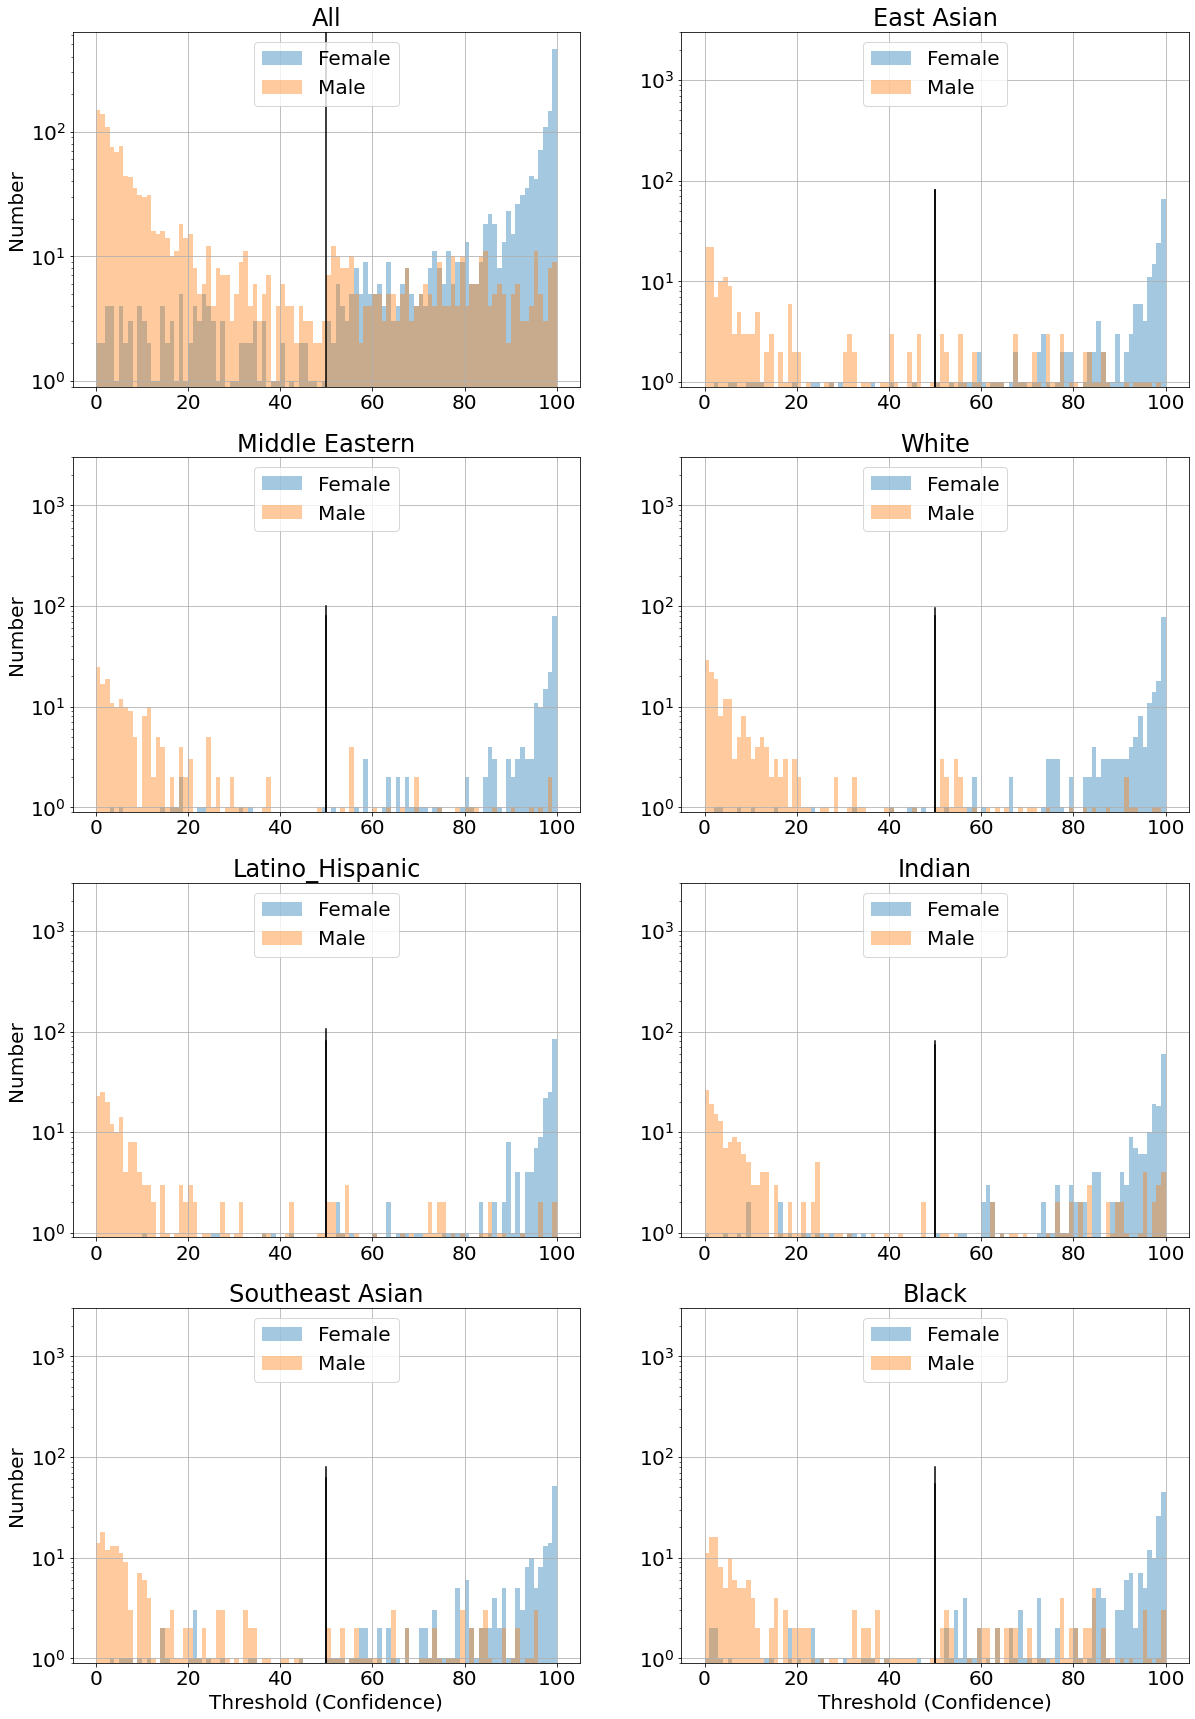

In [64]:
plt.rcParams.update({"font.size": 20})
plt.figure(figsize=(20,30))
plt.subplot(4,2,1)
plot_hists(label_list,pred_list,conf_list,title="All")
for i,race in enumerate(unique_race_list):
    race_bool = [value==race for value in race_list]
    race_labels = list(compress(label_list, race_bool))
    race_pred = list(compress(pred_list, race_bool))
    race_conf = list(compress(conf_list, race_bool))

    plt.subplot(4,2,i+2)
    plot_hists(race_labels,race_pred,race_conf,title=race)
    plt.ylim((0.9,3000))
    plt.plot([50, 50], [0, 80], color="black", linewidth=1.5)
plt.savefig('figures200/FairFace_Maleness_Femaleness.png')

In [66]:
def plot_error_hists(label_list, pred_list, conf_list, title=''):
  pos_class = "Female"
  pred_conf_label_list = [(pred,conf,label) for pred,conf,label in zip(pred_list,conf_list,label_list)]
  confidence_list = [(conf if pred==pos_class else 100.0 - conf,label) for pred,conf,label in pred_conf_label_list if pred!=label]
  hist_dict = dict()
  for gender in ["Female", "Male"]:
      gender_conf = [conf for conf,label in confidence_list if label==gender]
      ax = sns.distplot(gender_conf, kde=False,label=gender, bins=range(0,101))
  plt.legend(loc="upper center")
  if title=="Southeast Asian" or title=="Black":
      plt.xlabel("Threshold (Confidence)")
  if title=="All" or title=="Latino_Hispanic" or title=="Southeast Asian" or title=="Middle Eastern": 
      plt.ylabel("Number")
  _,top = plt.ylim()
  
  plt.plot([50, 50], [0, top], color="black", linewidth=1.5)
  plt.ylim((0,top))
  plt.grid(True)
  plt.title(title)

**Plots the Female-Male histograms only for the cases where Rekognition incorrectly predicted the gender:**

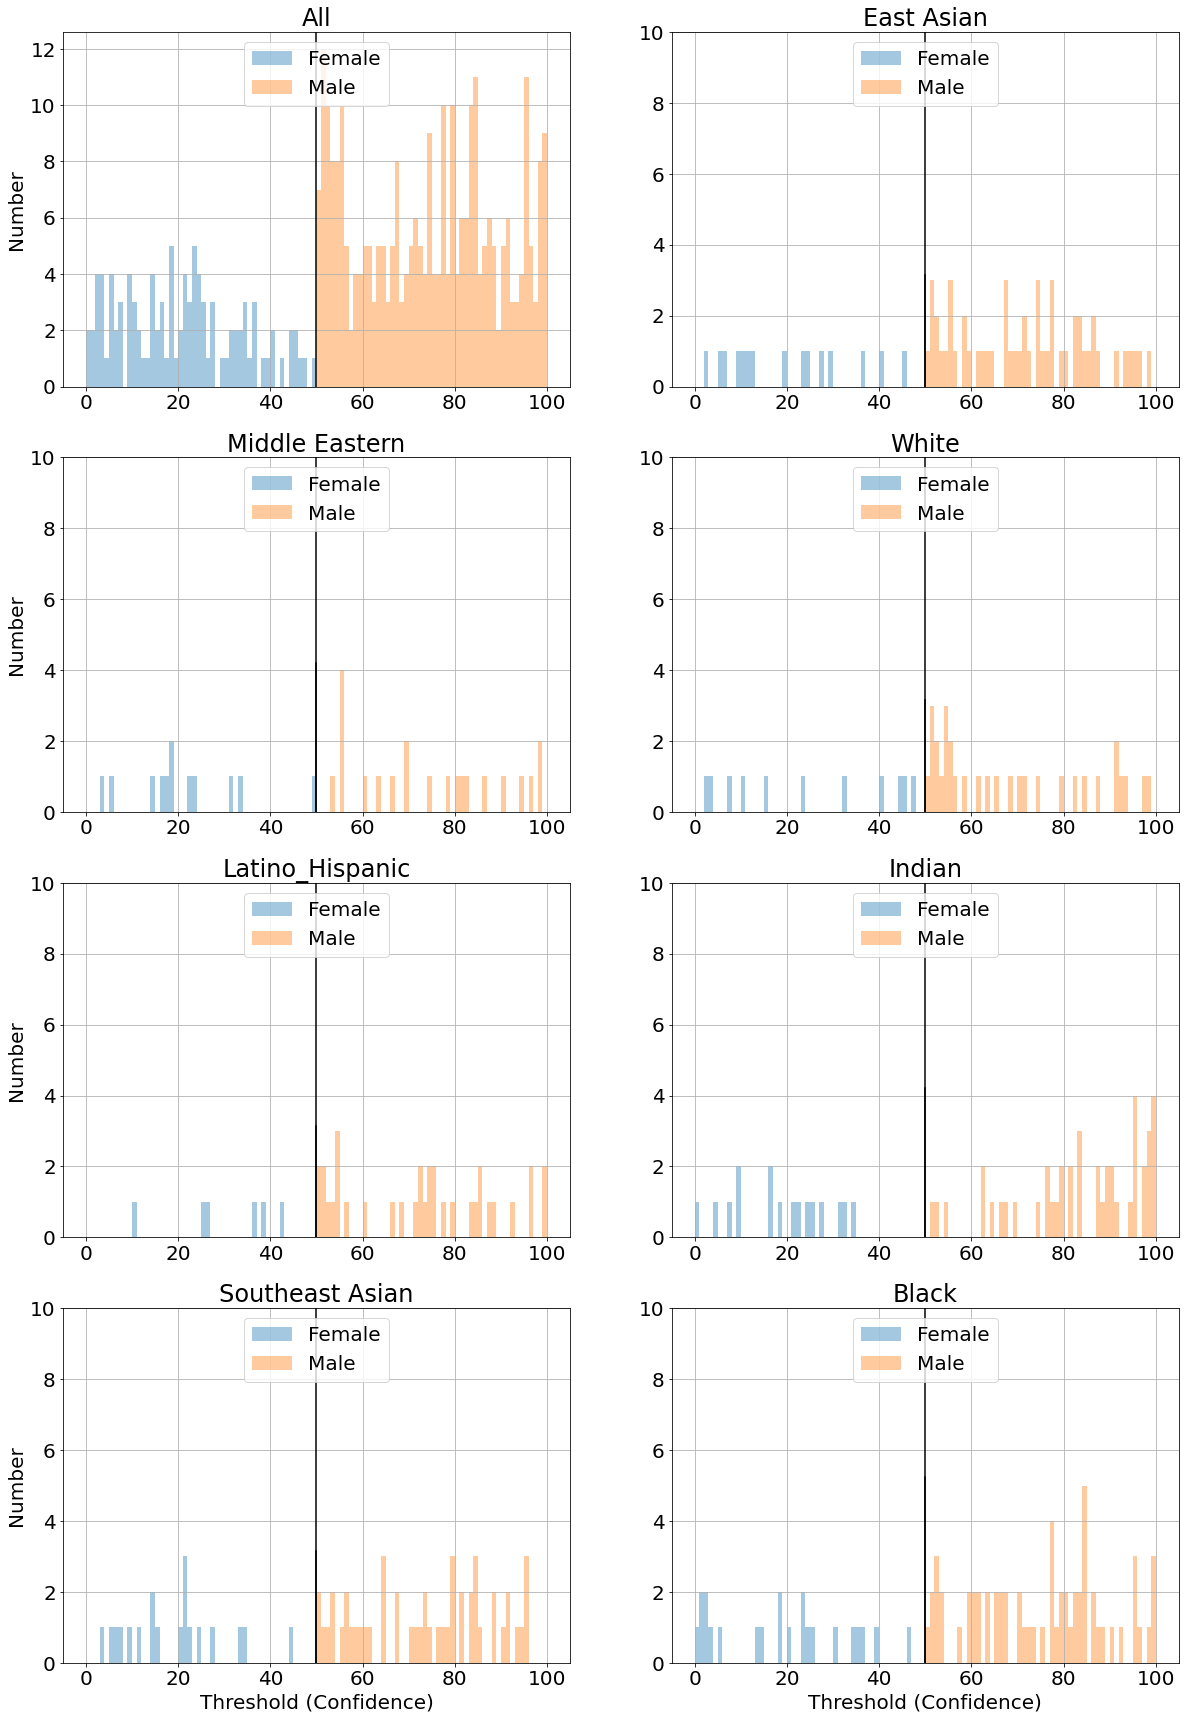

In [74]:
plt.figure(figsize=(20,30))
plt.subplot(4,2,1)
plot_error_hists(label_list,pred_list,conf_list,title="All")

for i,race in enumerate(unique_race_list):
    race_bool = [value==race for value in race_list]
    race_labels = list(compress(label_list, race_bool))
    race_pred = list(compress(pred_list, race_bool))
    race_conf = list(compress(conf_list, race_bool))

    plt.subplot(4,2,i+2)
    plot_error_hists(race_labels,race_pred,race_conf,title=race)
    plt.ylim((0,10))
    plt.plot([50, 50], [0, 10], color="black", linewidth=1.5)
plt.savefig("figures200/FairFace_Maleness_Femaleness-Error.png")